# 4.453x Creative Machine Learning for Design | Homework 1

## 0. Imports 📦

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import sklearn.neighbors

## 1. Download and inspect the dataset
We'll download the dataset to the local storage of this runtime. To do so easily, we'll use command line tool called `gdown` specifically designed to download files from Google Drive. In Colab, if you start a line of code with `!`, that line is run in the command line. This allows to install missing packages or download things easily from the web to the local storage. To install `gdown`, we just need to run `!pip install gdown`.

Note: you may have to run this cell twice to actually download the file to `dogs_cats.npz` as Colab sometimes returns a warning first.

In [ ]:
!pip install gdown > /dev/null
!gdown https://drive.google.com/uc?id=102DjdS-5-0x4GQ12H49u0yFv31-4kc5O 

Downloading...
From: https://drive.google.com/uc?id=102DjdS-5-0x4GQ12H49u0yFv31-4kc5O
To: /content/processedDogCat.npz
100% 540M/540M [00:01<00:00, 324MB/s]


Ok, so we've got our dataset in the file `processedDogCat.npz`. `.npz` is a special format that can be read by `numpy`, so let's load the data contained in the file in a variable.

In [ ]:
dataset = np.load("processedDogCat.npz", allow_pickle=True)

Let's inspect this dataset.

In [ ]:
print(list(dataset.keys()))

['X', 'Y']


We see the dataset has two entries `X` (the input features or images) and `Y` the target classes.

In [ ]:
X = dataset["X"]
Y = dataset["Y"]

### Question 1.1: Print the shapes of the X and Y arrays. How many samples are there in the dataset?  In other words, what are the dimensions of the X and Y arrays?  *Hint: the `np.shape` function may be useful here.*


In [ ]:
print("The shape of array X is:", np.shape(X))
print("The shape of array Y is:", np.shape(Y))

# The dataset has 1000 samples
# input matrix (X) has 1000 images, each at 150 x 150 px, and each image has 3 colors R G B channels
# output (Y) has 1000 labels


The shape of array X is: (1000, 150, 150, 3)
The shape of array Y is: (1000, 1)


### Question 1.2: Plot 5 random images from X (input)

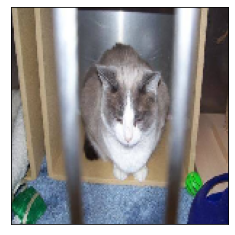

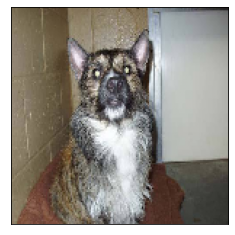

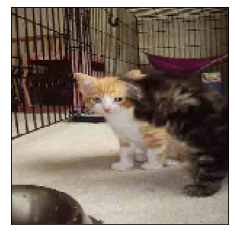

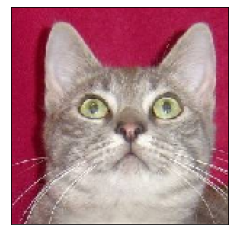

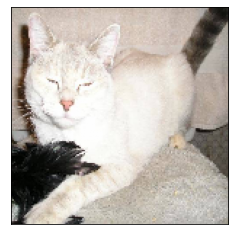

In [ ]:
# Plotting 5 random images
# print(X.shape[0])
sample_X = np.random.choice(X.shape[0], 5)
# print(sample_X)


# Function to plot each image
def random_sample_plot (x, sample_X):
  for i in sample_X:

    plt.figure()
    fig= plt.imshow(x[i])
    # Hide axis
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False) 
    plt.show()

random_sample_plot(X, sample_X)


### Question 1.3: What are the target labels in Y and which one corresponds to the "Dog" category?

In [ ]:
# Loop over the labels for the (5) sample indexies
for i in sample_X:
  print(Y[i])

# Dogs are labales as 0. Cats labeles as 1.

[0.]
[1.]
[1.]
[1.]
[1.]




```
# This is formatted as code
```

Each datapoint in the dataset ia a 150-by-150 RGB image and its associated class. First, we'll shuffle the dataset because it is currently ordered by class (not something you usually want for training). Shuffling the dataset will also allow you to easily set aside a part of your dataset for validation/testing.

### Question 1.4: Shuffle the dataset using `sklearn.utils.shuffle`  Remember that we want to keep X and Y together so that the class labels stay with their associated images.

In [ ]:
# Shuffle the datasets
X, Y = shuffle(X, Y, random_state=0)

### Question 1.5: What is the range of the pixel values?

In [ ]:
np.amin(X, axis=None), np.amax(X, axis=None)

# The range of the input X pixel value is min: 0.0, max: 1.0

(0.0, 1.0)

## 2. Processing the images into extracted features using VGG16
Take inspiration from the code in the [L01 notebook](https://colab.research.google.com/drive/1GTWORtS_bU__mH33_Mput_KYxYopqBuV?usp=sharing). Make sure to use the GPU!


You will need to resize the arrays/tensors from their current size (which is too small) to the minimum size accepted by VGG16 (224 by 224). To do so, we recommend you use `torchvision.transforms.Resize` (note this transformation can be applied on a batch of multiple images at once).

❗❗ Because we are handling many more images than we did in the lecture notebook, you may need to process them in batches (hint: you need to do it if you encounter a RAM or CUDA memory issue).

### Question 2.1: Convert the array X to a tensor

In [ ]:
# Setup GPU and import VGG16 model
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = torchvision.models.vgg16(pretrained=True).to(device)
cnn_model.eval()


# Convert arrays to tensors and permute (data, channel, dim, dim)
def process_arrays(x):
  return torch.Tensor(x).permute(0,3,1,2)
  
tensor_X = process_arrays(X).float().to(device)
tensor_X.shape

torch.Size([1000, 3, 150, 150])

### Question 2.2: Resize the image tensors. Remember that we need to permute the array to format the tensors in the anticipated way.

In [ ]:
# Image Resize Transform
transform_resize = torchvision.transforms.Resize(224)

### Question 2.3: Normalize the image tensors using the normalization constants expected by VGG16.

In [ ]:
# Image Normalize Transform
transform_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Combine all transforms
all_transforms = torchvision.transforms.Compose([transform_resize,transform_normalize])

print(all_transforms)

# Apply the transformations on tensor X
transformed_images = all_transforms(tensor_X)

print(transformed_images.shape)
# Permutes, resized and normalizes


Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1000, 3, 224, 224])


### Question 2.4: Project the image tensors to their bottleneck features

In [ ]:
# Extract features from the VGG cnn model
feature_extractor = cnn_model.features

# Splittin the images into batches of 25 to avoid memory issues
batch_split = np.arange(0, 1000, 100)
# print(batch_split)

# for i in batch_split:
#   batch_tensorX = [transformed_images[i:i+25]]

batch_tensorX = [transformed_images[index : index + 100] for index in batch_split]
# print(batch_tensorX)

featuresEx = []
# We don't need to keep track of gradients
with torch.no_grad():
  for i in batch_tensorX:
    extracted_features = feature_extractor(i)
    featuresEx.append(extracted_features)

# Concatenating the tensor features vertically
tensorX_feature = torch.cat(featuresEx, dim=0)
# print(tensorX_feature.shape)


### Question 2.5: Flatten the resulting *feature maps* (not the batches!)

---



In [ ]:
# Flatten the feature maps
tensorX_flatten = tensorX_feature.reshape(1000,-1)

print(tensorX_flatten.shape)

torch.Size([1000, 25088])


### Question 2.6: Convert the result back to numpy

In [ ]:
# Convert tensor arrays into numpy
X_array = tensorX_flatten.cpu().numpy()

print(X_array.shape, type(X_array))

(1000, 25088) <class 'numpy.ndarray'>


To be able to test how our model fares on unseen data, we need to set aside data that is not used during training. This data is our *validation* data and computing the accuracy of our model on this data gives us an idea of the *generalization error* of our model.

This is a really important process in ML, because in some sense predicting things perfectly on the training set does not matter (think of how stupidly replicating the data achieves perfect prediction). Generally, you would even want another test set, but we'll talk more about this in later weeks.

### Question 2.7: Separate the dataset in a training set (90% of the data) and a validation set (10% of the data)

In [ ]:
# Split into train test sets using train_test_split sklearn.model function
X_train, X_validation, Y_train, Y_validation = train_test_split(X_array, Y, test_size=0.10, random_state=10)

print(X_train.shape)
print(X_validation.shape)

# Flattening Y train and validation dataset
Y_train = Y_train.ravel()
print(Y_train.shape)
Y_validation = Y_validation.ravel()
print(Y_validation.shape)


(900, 25088)
(100, 25088)
(900,)
(100,)


## 3. Fit k-NN model
Like in the [L01 notebook](https://colab.research.google.com/drive/1GTWORtS_bU__mH33_Mput_KYxYopqBuV?usp=sharing), fit a k-nearest neighbors model with $k=10$ to your training set.

Remember, the task of the model is to try to predict whether a given image shows a dog or a cat. This is a VERY important model that could change the world as we know it. 🚨🚨🚨🚨

### Question 3.1: Fit a k-nearest neighbors model to your training set

In [ ]:
n_neighbors = 10

# Setting the classifier
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights="uniform")

# Fit the training model
classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

### Question 3.2: Compute the accuracy of the model on the training and validation sets (separately). Is the model doing well? 
❗ Record the values found and your observations in the Google Doc you link at the end of the notebook.

Hint: we measure accuracy as `number_correct_predictions/total_number_predictions`. 

In [ ]:
# Accuracy on the validation set
# Getting prdictions
Y_validation_predict = classifier.predict(X_validation)
# Finding accurate predictions, accurate = 1, wrong = 0
Y_validation_res = np.where(Y_validation_predict == Y_validation, 1, 0)
# Calculating accuracy  correct predictions / total predictions
validation_accur = np.sum(Y_validation_res/100)
print("The accuracy on the validation set is:", validation_accur)

# Accuracy on the testing set
Y_train_predict = classifier.predict(X_train)
# Finding accurate predictions, accurate = 1, wrong = 0
Y_train_res = np.where(Y_train_predict == Y_train, 1, 0)
# Calculating accuracy  correct predictions / total predictions
testing_accu = np.sum(Y_train_res/900)
print("The accuracy on the training set is:", testing_accu)

The accuracy on the validation set is: 0.73
The accuracy on the training set is: 0.7955555555555556


### Question 3.3: Plot images of 5 good predictions and 5 bad predictions. Can you observe patterns in the bad prediction?
❗ Record these images and your observations in the Google Doc you link at the end of the notebook.

Good prediciton [sample of 5 images]:


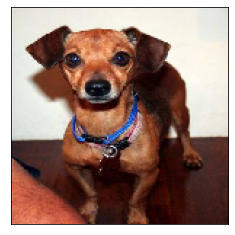

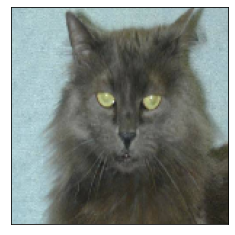

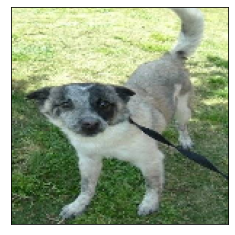

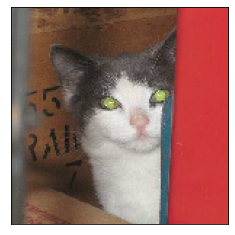

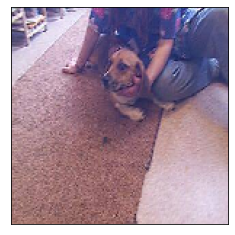

Wrong prediciton [sample of 5 images]:


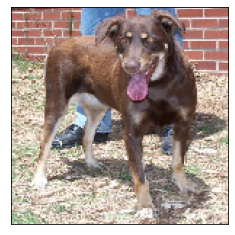

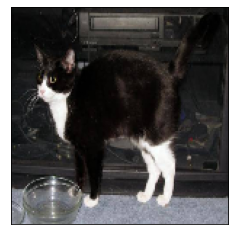

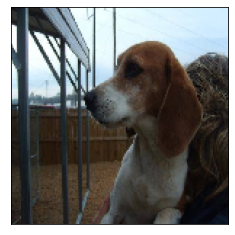

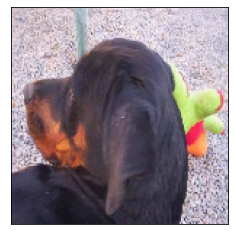

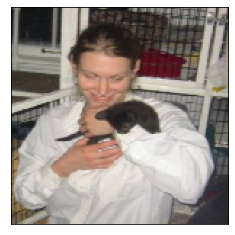

In [ ]:
# Find the index of the good predictions on the validation data set
good_train_predict_i = np.where(Y_train_res == 1)[0]
# print(good_validation_predict_i)
wrong_train_predict_i = np.where(Y_train_res == 0)[0]
# print(wrong_validation_predict_i)

# Select 5 random good preditions to plot
plot_good_train = np.random.choice(good_train_predict_i, 5)
# print(plot_good_validation)
print("Good prediciton [sample of 5 images]:")
random_sample_plot(X, plot_good_train)

# Select 5 random good preditions to plot
plot_wrong_train = np.random.choice(wrong_train_predict_i, 5)
# print(plot_wrong_validation)
print("Wrong prediciton [sample of 5 images]:")
random_sample_plot(X, plot_wrong_train)


### Question 3.4: Test 5 different values of $k$ and compute the validation accuracy of each resulting model. What is the best of value of $k$ that you found?
❗ Record your observations in the Google Doc you link at the end of the notebook.
